In [ ]:
# Cell 1: Clean environment setup (no Google Drive)

# Install needed packages
!pip install --quiet openpyxl lightgbm xgboost

# Standard imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Create project folder
WORKDIR = "/content/home_credit_project"
os.makedirs(WORKDIR, exist_ok=True)

print("Environment ready. Working directory:", WORKDIR)

Environment ready. Working directory: /content/home_credit_project


In [ ]:
# Cell 2: Upload the Archive(2).zip file from your local machine

from google.colab import files
uploaded = files.upload()

# After running this, choose:  Archive(2).zip


Saving archive (2).zip to archive (2) (2).zip


In [ ]:
# Cell 3: Extract the ZIP file and list its contents

import zipfile
import os

# Get the uploaded filename (should be Archive(2).zip)
zip_filename = list(uploaded.keys())[0]
print("Uploaded ZIP:", zip_filename)

# Create extraction folder
extract_dir = "/content/home_credit_raw"
os.makedirs(extract_dir, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_filename, 'r') as z:
    z.extractall(extract_dir)

print("Files extracted to:", extract_dir)
print("\nList of extracted files:")
!ls -l /content/home_credit_raw


Uploaded ZIP: archive (2) (2).zip
Files extracted to: /content/home_credit_raw

List of extracted files:
total 560932
-rw-r--r-- 1 root root 166133370 Nov 20 20:50  application_data.csv
-rw-r--r-- 1 root root     18777 Nov 20 20:50  columns_description.xlsx
-rw-r--r-- 1 root root   3264046 Nov 20 20:50 'Credit EDA Case Study.pdf'
-rw-r--r-- 1 root root 404973293 Nov 20 20:50  previous_application.csv


In [ ]:
# Cell 4 (fixed): Load your actual dataset filenames

import pandas as pd
import os

data_path = "/content/home_credit_raw"

# Load main current application file
app_train = pd.read_csv(os.path.join(data_path, "application_data.csv"))

# Load previous loans file
prev_app = pd.read_csv(os.path.join(data_path, "previous_application.csv"))

print("application_data shape:", app_train.shape)
print("previous_application shape:", prev_app.shape)

app_train.head(), prev_app.head()


application_data shape: (307511, 122)
previous_application shape: (1670214, 37)


(   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
 0      100002       1         Cash loans           M            N   
 1      100003       0         Cash loans           F            N   
 2      100004       0    Revolving loans           M            Y   
 3      100006       0         Cash loans           F            N   
 4      100007       0         Cash loans           M            N   
 
   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
 0               Y             0          202500.0    406597.5      24700.5   
 1               N             0          270000.0   1293502.5      35698.5   
 2               Y             0           67500.0    135000.0       6750.0   
 3               Y             0          135000.0    312682.5      29686.5   
 4               Y             0          121500.0    513000.0      21865.5   
 
    ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
 0  ...               

In [ ]:
# Cell 5: Aggregate previous_application by SK_ID_CURR

# 1) Select numeric columns for aggregation
numeric_cols = prev_app.select_dtypes(include=['int64', 'float64']).columns

# 2) Aggregate numeric features: mean, max, min
prev_numeric_agg = prev_app.groupby("SK_ID_CURR")[numeric_cols].agg(['mean', 'min', 'max'])
prev_numeric_agg.columns = ['PREV_' + '_'.join(col) for col in prev_numeric_agg.columns]

# 3) Count number of previous applications
prev_count = prev_app.groupby("SK_ID_CURR").size().reset_index(name='PREV_LOAN_COUNT')

# 4) Count status categories (Approved / Refused)
prev_status = (
    prev_app.groupby(["SK_ID_CURR", "NAME_CONTRACT_STATUS"])
            .size()
            .unstack(fill_value=0)
            .add_prefix("PREV_STATUS_")
)

# 5) Merge all aggregates into one table
prev_agg = prev_numeric_agg.merge(prev_count, on="SK_ID_CURR", how="left")
prev_agg = prev_agg.merge(prev_status, on="SK_ID_CURR", how="left")

print("Previous-loan aggregated table shape:", prev_agg.shape)
prev_agg.head()


Previous-loan aggregated table shape: (338857, 69)


,SK_ID_CURR,PREV_SK_ID_PREV_mean,PREV_SK_ID_PREV_min,PREV_SK_ID_PREV_max,PREV_SK_ID_CURR_mean,PREV_SK_ID_CURR_min,PREV_SK_ID_CURR_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,...,PREV_DAYS_TERMINATION_min,PREV_DAYS_TERMINATION_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_LOAN_COUNT,PREV_STATUS_Approved,PREV_STATUS_Canceled,PREV_STATUS_Refused,PREV_STATUS_Unused offer
0,100001,1.369693e+06,1369693,1369693,100001.0,100001,100001,3951.000,3951.000,3951.000,...,-1612.0,-1612.0,0.000000,0.0,0.0,1,1,0,0,0
1,100002,1.038818e+06,1038818,1038818,100002.0,100002,100002,9251.775,9251.775,9251.775,...,-17.0,-17.0,0.000000,0.0,0.0,1,1,0,0,0
2,100003,2.281150e+06,1810518,2636178,100003.0,100003,100003,56553.990,6737.310,98356.995,...,-1976.0,-527.0,0.666667,0.0,1.0,3,3,0,0,0
3,100004,1.564014e+06,1564014,1564014,100004.0,100004,100004,5357.250,5357.250,5357.250,...,-714.0,-714.0,0.000000,0.0,0.0,1,1,0,0,0
4,100005,2.176837e+06,1857999,2495675,100005.0,100005,100005,4813.200,4813.200,4813.200,...,-460.0,-460.0,0.000000,0.0,0.0,2,1,1,0,0


In [ ]:
# Cell 6: Merge application_data with the aggregated previous loan features

# Merge on SK_ID_CURR
master_df = app_train.merge(prev_agg, on="SK_ID_CURR", how="left")

print("Master dataset shape:", master_df.shape)
master_df.head()


Master dataset shape: (307511, 190)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_DAYS_TERMINATION_min,PREV_DAYS_TERMINATION_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_LOAN_COUNT,PREV_STATUS_Approved,PREV_STATUS_Canceled,PREV_STATUS_Refused,PREV_STATUS_Unused offer
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-17.0,-17.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1976.0,-527.0,0.666667,0.0,1.0,3.0,3.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-714.0,-714.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-416.0,365243.0,0.000000,0.0,0.0,9.0,5.0,3.0,1.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-2041.0,365243.0,0.600000,0.0,1.0,6.0,6.0,0.0,0.0,0.0


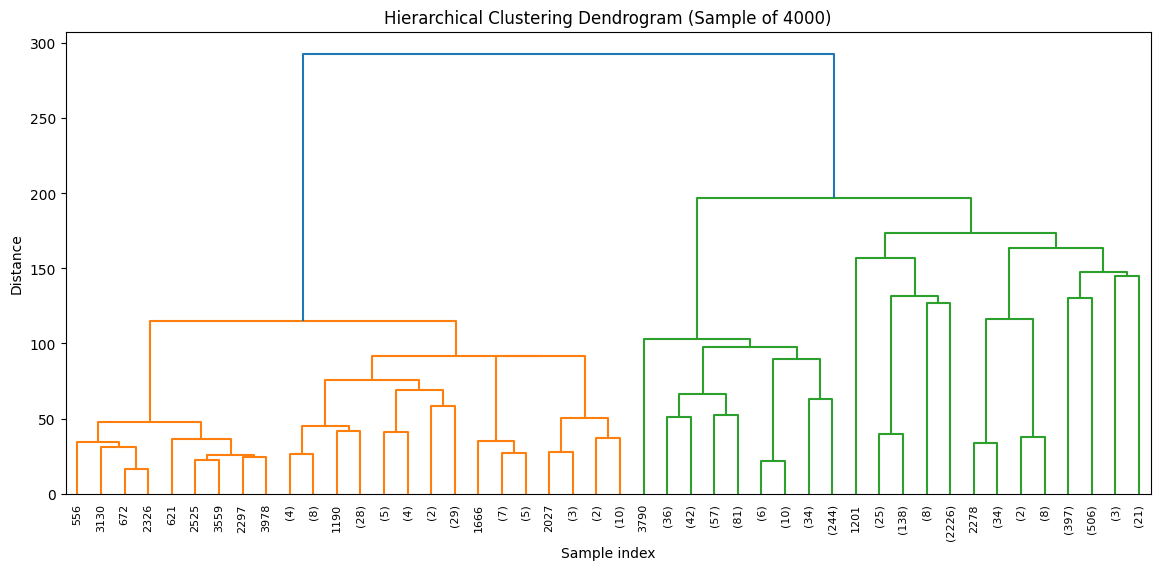

In [ ]:
# Cell 9: Plot dendrogram using a sample (large datasets cannot be fully plotted)

from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Take a random sample of 4000 rows for the dendrogram
sample_pca = pca_df.sample(4000, random_state=RANDOM_STATE)

# Perform hierarchical clustering linkage
Z = linkage(sample_pca, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 6))
plt.title("Hierarchical Clustering Dendrogram (Sample of 4000)")
dendrogram(Z, truncate_mode='level', p=5)
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()


New try




In [ ]:
# CELL 1 — Clean Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

print("Environment Ready")


Environment Ready


In [ ]:
# CELL 2 — Load Datasets Fresh

import os

data_path = "/content/home_credit_raw"

# Load application data
app_train = pd.read_csv(os.path.join(data_path, "application_data.csv"))

# Load previous applications
prev_app = pd.read_csv(os.path.join(data_path, "previous_application.csv"))

print("application_data shape:", app_train.shape)
print("previous_application shape:", prev_app.shape)

app_train.head(), prev_app.head()


application_data shape: (307511, 122)
previous_application shape: (1670214, 37)


(   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
 0      100002       1         Cash loans           M            N   
 1      100003       0         Cash loans           F            N   
 2      100004       0    Revolving loans           M            Y   
 3      100006       0         Cash loans           F            N   
 4      100007       0         Cash loans           M            N   
 
   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
 0               Y             0          202500.0    406597.5      24700.5   
 1               N             0          270000.0   1293502.5      35698.5   
 2               Y             0           67500.0    135000.0       6750.0   
 3               Y             0          135000.0    312682.5      29686.5   
 4               Y             0          121500.0    513000.0      21865.5   
 
    ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
 0  ...               

In [ ]:
# CELL 3 — Aggregate previous_application

# 1) Select numerical columns from previous_application
prev_num = prev_app.select_dtypes(include=['int64', 'float64'])

# 2) Aggregate numeric columns (mean, min, max)
prev_agg_numeric = prev_num.groupby(prev_app['SK_ID_CURR']).agg(['mean', 'min', 'max'])

# Flatten column names
prev_agg_numeric.columns = [
    f"PREV_{col}_{stat}".upper() for col, stat in prev_agg_numeric.columns
]

# 3) Count how many previous applications each customer made
prev_count = prev_app.groupby('SK_ID_CURR').size().reset_index(name='PREV_APPLICATION_COUNT')

# 4) Contract status counts (Approved, Refused, etc.)
prev_status = (
    prev_app.groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
            .size()
            .unstack(fill_value=0)
)

# Rename: PREV_STATUS_APPROVED, PREV_STATUS_REFUSED, etc.
prev_status.columns = [f"PREV_STATUS_{col}".upper() for col in prev_status.columns]

# 5) Combine all aggregates
prev_agg = (
    prev_agg_numeric
    .merge(prev_count, on='SK_ID_CURR', how='left')
    .merge(prev_status, on='SK_ID_CURR', how='left')
)

print("Aggregated previous loan table shape:", prev_agg.shape)
prev_agg.head()


Aggregated previous loan table shape: (338857, 69)


,SK_ID_CURR,PREV_SK_ID_PREV_MEAN,PREV_SK_ID_PREV_MIN,PREV_SK_ID_PREV_MAX,PREV_SK_ID_CURR_MEAN,PREV_SK_ID_CURR_MIN,PREV_SK_ID_CURR_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,...,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_MIN,PREV_NFLAG_INSURED_ON_APPROVAL_MAX,PREV_APPLICATION_COUNT,PREV_STATUS_APPROVED,PREV_STATUS_CANCELED,PREV_STATUS_REFUSED,PREV_STATUS_UNUSED OFFER
0,100001,1.369693e+06,1369693,1369693,100001.0,100001,100001,3951.000,3951.000,3951.000,...,-1612.0,-1612.0,0.000000,0.0,0.0,1,1,0,0,0
1,100002,1.038818e+06,1038818,1038818,100002.0,100002,100002,9251.775,9251.775,9251.775,...,-17.0,-17.0,0.000000,0.0,0.0,1,1,0,0,0
2,100003,2.281150e+06,1810518,2636178,100003.0,100003,100003,56553.990,6737.310,98356.995,...,-1976.0,-527.0,0.666667,0.0,1.0,3,3,0,0,0
3,100004,1.564014e+06,1564014,1564014,100004.0,100004,100004,5357.250,5357.250,5357.250,...,-714.0,-714.0,0.000000,0.0,0.0,1,1,0,0,0
4,100005,2.176837e+06,1857999,2495675,100005.0,100005,100005,4813.200,4813.200,4813.200,...,-460.0,-460.0,0.000000,0.0,0.0,2,1,1,0,0


In [ ]:
# CELL 4 — Merge application_data with aggregated previous loans

master_df = app_train.merge(prev_agg, on='SK_ID_CURR', how='left')

print("Master dataset shape:", master_df.shape)

# Show first few rows
master_df.head()


Master dataset shape: (307511, 190)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_MIN,PREV_NFLAG_INSURED_ON_APPROVAL_MAX,PREV_APPLICATION_COUNT,PREV_STATUS_APPROVED,PREV_STATUS_CANCELED,PREV_STATUS_REFUSED,PREV_STATUS_UNUSED OFFER
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-17.0,-17.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1976.0,-527.0,0.666667,0.0,1.0,3.0,3.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-714.0,-714.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-416.0,365243.0,0.000000,0.0,0.0,9.0,5.0,3.0,1.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-2041.0,365243.0,0.600000,0.0,1.0,6.0,6.0,0.0,0.0,0.0


In [ ]:
# CELL 6 — Correct variance filtering BEFORE scaling

from sklearn.feature_selection import VarianceThreshold

# 1) Select numeric columns only
numeric_df = master_df.select_dtypes(include=['int64', 'float64']).copy()

print("Numeric columns:", numeric_df.shape)

# 2) Replace inf with NaN
numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3) Fill NaN with median
numeric_df = numeric_df.fillna(numeric_df.median())

# 4) Variance threshold BEFORE scaling (threshold = 5.0)
vt = VarianceThreshold(threshold=5.0)
numeric_var = vt.fit_transform(numeric_df)

print("After variance threshold:", numeric_var.shape)

# Convert back to DataFrame
numeric_var_df = pd.DataFrame(numeric_var)


Numeric columns: (307511, 174)
After variance threshold: (307511, 63)


In [ ]:
# CELL 7 — Scaling AFTER variance filtering

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(pd.DataFrame(numeric_var))

print("Scaled shape:", numeric_scaled.shape)

# Save as input for PCA
pca_input = numeric_scaled

# Show first few rows
pd.DataFrame(pca_input).head()


Scaled shape: (307511, 63)


,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,-1.733423,0.142129,-0.478095,-0.166143,-0.507236,1.506880,-0.456215,0.379837,0.579154,-0.146313,...,-0.477817,-0.057794,-0.584914,-0.715555,-0.254343,-0.915156,-0.793686,-0.269426,-1.092069,-0.943576
1,-1.733413,0.426792,1.725450,0.592683,1.600873,-0.166821,-0.460115,1.078697,1.790855,-0.146313,...,-0.496677,-0.118899,-0.588119,-0.725236,-0.275653,-0.917960,-0.803285,-0.289847,-1.094869,-0.448425
2,-1.733403,-0.427196,-1.152888,-1.404669,-1.092145,-0.689509,-0.453299,0.206116,0.306869,2.242932,...,-0.491494,-0.081568,-0.590051,-0.722129,-0.261962,-0.918992,-0.800180,-0.276692,-1.095896,-0.943576
3,-1.733384,-0.142533,-0.711430,0.177874,-0.653463,-0.680114,-0.473217,-1.375829,0.369143,-0.146313,...,1.049552,-0.067663,1.705136,1.000921,-0.258703,1.089454,0.906647,-0.273585,0.913158,1.037028
4,-1.733374,-0.199466,-0.213734,-0.361749,-0.068554,-0.892535,-0.473210,0.191639,-0.307263,-0.146313,...,-0.493885,-0.121105,-0.583528,-0.036863,-0.276481,1.089454,-0.121367,-0.290525,0.913158,0.294302


In [ ]:
# CELL 8 — PCA correctly applied

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Fit PCA to compute variance contribution
pca = PCA().fit(pca_input)

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

# Number of components for 90% variance
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print("Components needed for 90% variance:", n_components_90)

# Fit PCA again using this number
pca_final = PCA(n_components=n_components_90)
pca_data = pca_final.fit_transform(pca_input)

# Convert to DataFrame
pca_df = pd.DataFrame(
    pca_data,
    columns=[f"PCA_{i+1}" for i in range(n_components_90)]
)

print("PCA dataframe shape:", pca_df.shape)
pca_df.head()


Components needed for 90% variance: 23
PCA dataframe shape: (307511, 23)


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23
0,-1.174751,-3.221682,1.653835,-3.535670,1.043824,-1.927164,0.142763,-0.441573,0.413520,1.666987,...,0.325210,-1.030542,1.921371,0.050380,-0.595467,0.594841,0.281139,0.232445,-1.003246,-0.133814
1,4.521198,-3.051347,-1.320610,-3.555113,-2.081802,1.147245,-0.113258,-0.547358,1.308907,1.284245,...,0.851032,-0.307003,-3.064771,-1.229547,0.790669,-0.866002,0.541596,-0.572992,1.578434,-1.130082
2,-3.974888,-0.907833,-0.233746,-3.568505,1.720212,-4.035319,0.123395,1.451434,0.142498,2.054846,...,0.586297,-0.104622,-0.284474,-0.343265,2.259805,0.342999,0.330620,-0.282839,-0.346502,0.025170
3,3.659675,2.979713,0.114853,-3.550949,0.755807,2.225738,0.105948,2.277347,-1.584529,-0.795307,...,1.150250,1.106577,0.937238,-0.315779,0.036916,-0.184094,1.767536,-0.208358,-0.425151,0.863660
4,0.048797,0.387115,-1.115501,-3.556877,1.489181,-0.410496,0.088963,-0.303443,-0.022948,-0.746058,...,0.007363,-1.078764,0.581071,0.807930,-0.642667,-0.107143,-0.059224,0.092831,0.249313,0.099928


In [ ]:
# CELL 9 — FIXED & STABLE HIERARCHICAL CLUSTERING PIPELINE

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin
import numpy as np

# ---------------------------------------------------------
# 1) SAMPLE USING FIRST 10,000 ROWS (keeps ordering stable)
# ---------------------------------------------------------
sample_size = 10000
pca_sample = pca_df.iloc[:sample_size].copy()
pca_sample_np = pca_sample.values

print("Sample shape:", pca_sample_np.shape)

# ---------------------------------------------------------
# 2) HIERARCHICAL CLUSTERING ON ORDERED SAMPLE
# ---------------------------------------------------------
agg = AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward'
)

sample_labels = agg.fit_predict(pca_sample_np)
pca_sample["CLUSTER_ID"] = sample_labels

print("Sample cluster counts:")
print(pca_sample["CLUSTER_ID"].value_counts())

# ---------------------------------------------------------
# 3) COMPUTE CENTROIDS (MEAN PC SCORES PER CLUSTER)
# ---------------------------------------------------------
centroids = []
for c in range(3):
    centroids.append(
        pca_sample[pca_sample.CLUSTER_ID == c].iloc[:, :-1].mean().values
    )
centroids = np.array(centroids)

print("Centroids shape:", centroids.shape)

# ---------------------------------------------------------
# 4) ASSIGN ALL 307k CUSTOMERS TO CLOSEST CLUSTER
# ---------------------------------------------------------
pca_full_np = pca_df.values
full_labels = pairwise_distances_argmin(pca_full_np, centroids)

master_df["CLUSTER_ID"] = full_labels

# ---------------------------------------------------------
# 5) SHOW FINAL CLUSTER DISTRIBUTION
# ---------------------------------------------------------
print("Final clusters:")
print(master_df["CLUSTER_ID"].value_counts())

master_df[["SK_ID_CURR", "CLUSTER_ID"]].head()


Sample shape: (10000, 23)
Sample cluster counts:
CLUSTER_ID
2    5471
0    2487
1    2042
Name: count, dtype: int64
Centroids shape: (3, 23)
Final clusters:
CLUSTER_ID
2    172189
0     74945
1     60377
Name: count, dtype: int64


,SK_ID_CURR,CLUSTER_ID
0,100002,2
1,100003,1
2,100004,2
3,100006,1
4,100007,2


In [ ]:
# CELL 10 — ANOVA test to validate clusters

from scipy.stats import f_oneway

# Choose 3 meaningful numeric features
features_to_test = ["AMT_INCOME_TOTAL", "DAYS_BIRTH", "AMT_CREDIT"]

anova_results = {}

for feature in features_to_test:
    group0 = master_df[master_df.CLUSTER_ID == 0][feature]
    group1 = master_df[master_df.CLUSTER_ID == 1][feature]
    group2 = master_df[master_df.CLUSTER_ID == 2][feature]

    f_stat, p_val = f_oneway(group0, group1, group2)
    anova_results[feature] = (f_stat, p_val)

# Display results
for feature, (f, p) in anova_results.items():
    print(f"{feature}: F-statistic = {f:.2f},  p-value = {p:.5e}")


AMT_INCOME_TOTAL: F-statistic = 1242.03,  p-value = 0.00000e+00
DAYS_BIRTH: F-statistic = 3339.84,  p-value = 0.00000e+00
AMT_CREDIT: F-statistic = 4689.75,  p-value = 0.00000e+00


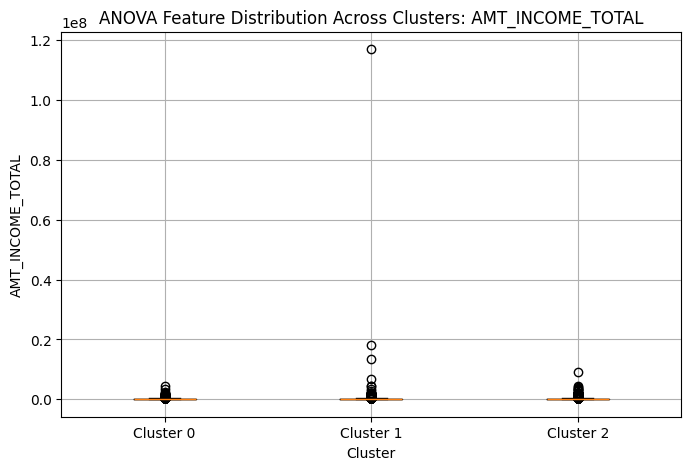

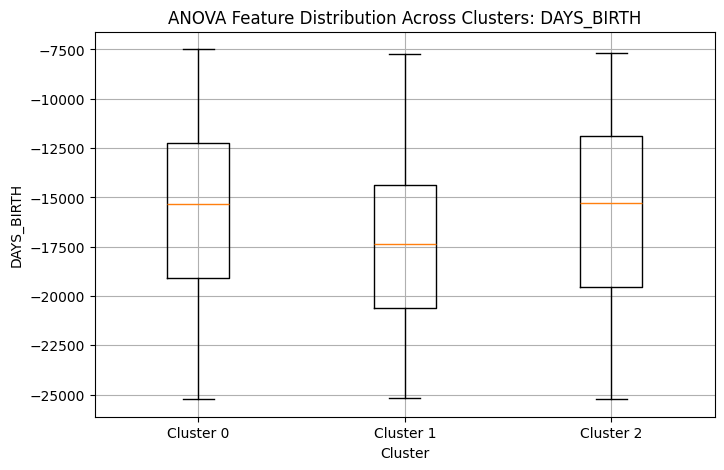

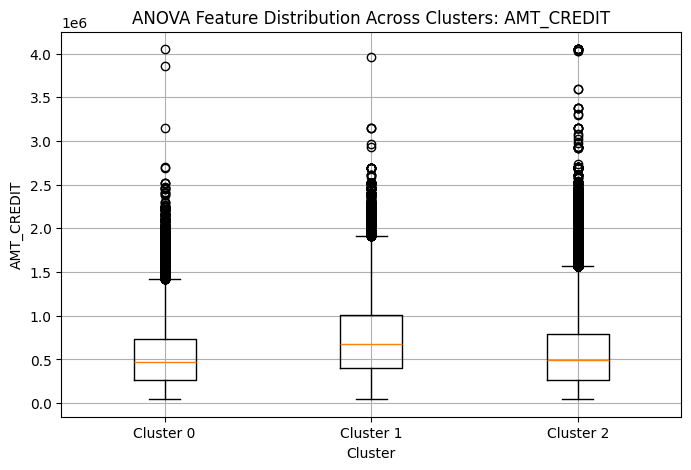

In [ ]:
# CELL — ANOVA Box Plots

import matplotlib.pyplot as plt

# Features you tested in ANOVA
features_to_plot = ["AMT_INCOME_TOTAL", "DAYS_BIRTH", "AMT_CREDIT"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))

    # Prepare boxplot data
    data = [
        master_df[master_df["CLUSTER_ID"] == 0][feature],
        master_df[master_df["CLUSTER_ID"] == 1][feature],
        master_df[master_df["CLUSTER_ID"] == 2][feature]
    ]

    plt.boxplot(data, labels=["Cluster 0", "Cluster 1", "Cluster 2"])
    plt.title(f"ANOVA Feature Distribution Across Clusters: {feature}")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


In [ ]:
# CELL 11 — Cluster Profiling

profile_features = [
    "AMT_INCOME_TOTAL",
    "DAYS_BIRTH",
    "AMT_CREDIT",
    "DAYS_EMPLOYED",
    "CNT_CHILDREN",
    "AMT_ANNUITY"
]

cluster_profile = master_df.groupby("CLUSTER_ID")[profile_features].mean()

print("Cluster Profiles (mean values):")
cluster_profile


Cluster Profiles (mean values):


,AMT_INCOME_TOTAL,DAYS_BIRTH,AMT_CREDIT,DAYS_EMPLOYED,CNT_CHILDREN,AMT_ANNUITY
CLUSTER_ID,,,,,,
0,159667.556492,-15668.664607,538050.402575,54100.758343,0.437561,24948.528356
1,211712.108107,-17322.709492,735137.387871,73033.547477,0.348096,31857.030759
2,157724.302879,-15746.482586,577838.925291,64810.764631,0.432304,26383.756930


In [ ]:
# CELL 12 — LDA (Linear Discriminant Analysis)

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# FEATURES: PCA components + cluster ID
X = pd.concat([pca_df, master_df["CLUSTER_ID"]], axis=1)
y = master_df["TARGET"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predict
y_pred = lda.predict(X_test)

print("LDA Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


LDA Accuracy: 0.9195323805342829

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



In [ ]:
# CELL 13 — QDA

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

# Fit model
qda.fit(X_train, y_train)

# Predict
y_pred_qda = qda.predict(X_test)

print("QDA Accuracy:", accuracy_score(y_test, y_pred_qda))
print("\nClassification Report:\n", classification_report(y_test, y_pred_qda))


QDA Accuracy: 0.6909906833812984

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.71      0.81     56554
           1       0.12      0.47      0.20      4949

    accuracy                           0.69     61503
   macro avg       0.53      0.59      0.50     61503
weighted avg       0.87      0.69      0.76     61503



In [ ]:
# CELL 14 — Gaussian Naive Bayes (Bayesian Estimation)

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

# Train model
gnb.fit(X_train, y_train)

# Predict
y_pred_gnb = gnb.predict(X_test)

print("GNB Accuracy:", accuracy_score(y_test, y_pred_gnb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gnb))


GNB Accuracy: 0.7967416223598849

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88     56554
           1       0.14      0.29      0.18      4949

    accuracy                           0.80     61503
   macro avg       0.53      0.56      0.53     61503
weighted avg       0.87      0.80      0.83     61503



In [ ]:
# CELL 15 — Logistic Regression Baseline

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",   # important for imbalanced credit data
    solver="lbfgs"
)

# Train model
log_reg.fit(X_train, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.5867356063931841

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.58      0.72     56554
           1       0.12      0.63      0.20      4949

    accuracy                           0.59     61503
   macro avg       0.53      0.61      0.46     61503
weighted avg       0.88      0.59      0.68     61503



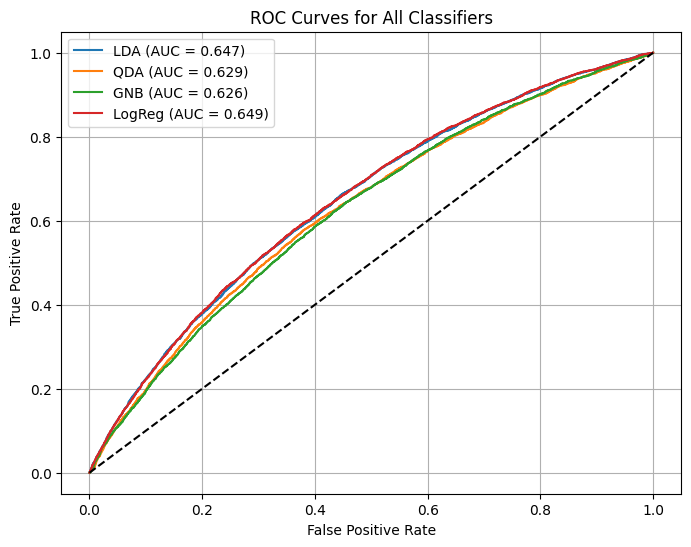

In [ ]:
# CELL 16 — ROC Curves for All Models

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {
    "LDA": lda,
    "QDA": qda,
    "GNB": gnb,
    "LogReg": log_reg
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Classifiers")
plt.legend()
plt.grid(True)
plt.show()


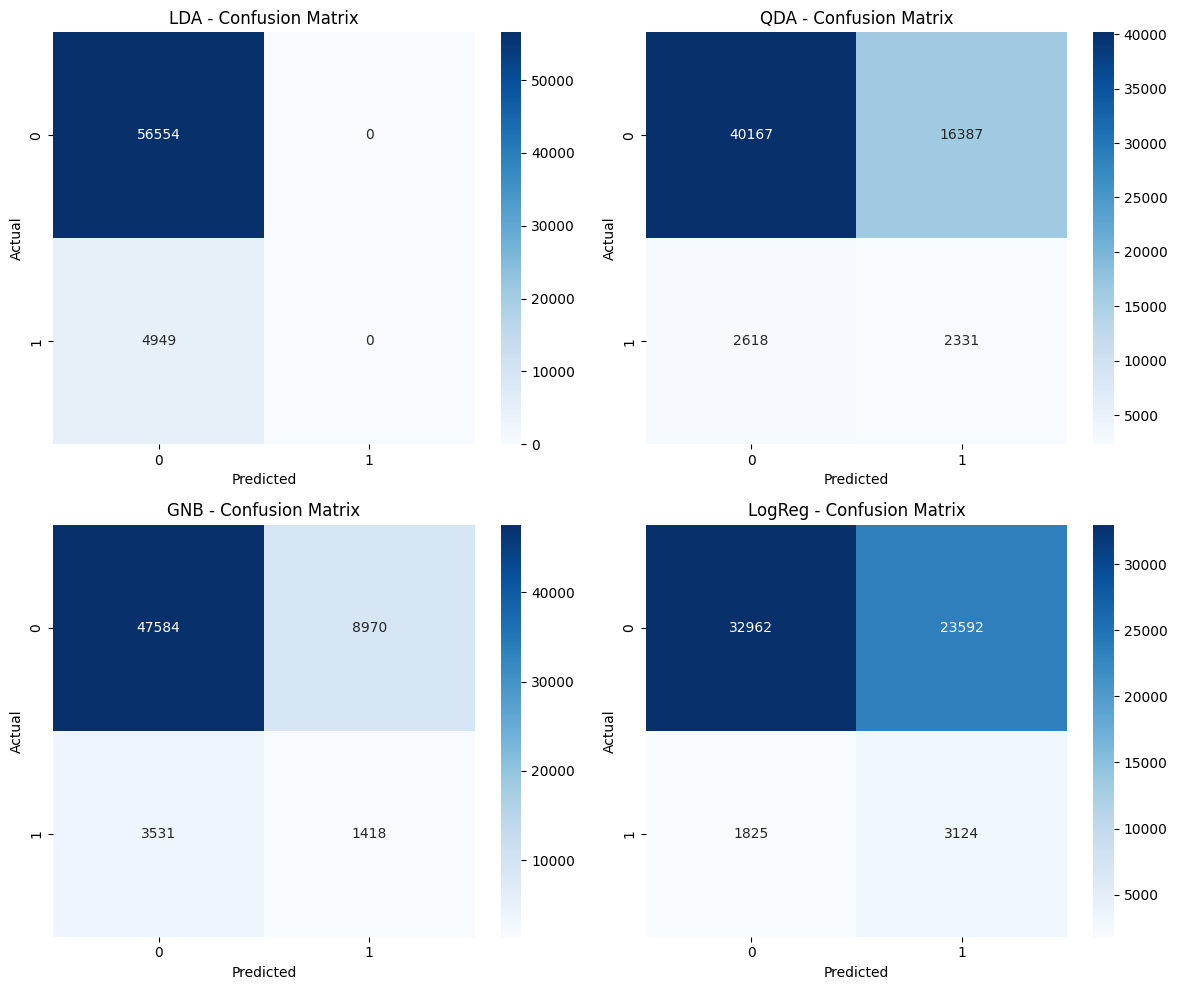

In [ ]:
# VISUAL 1 — Confusion Matrices
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "LDA": lda,
    "QDA": qda,
    "GNB": gnb,
    "LogReg": log_reg
}

plt.figure(figsize=(12,10))

i = 1
for name, model in models.items():
    plt.subplot(2,2,i)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    i += 1

plt.tight_layout()
plt.show()


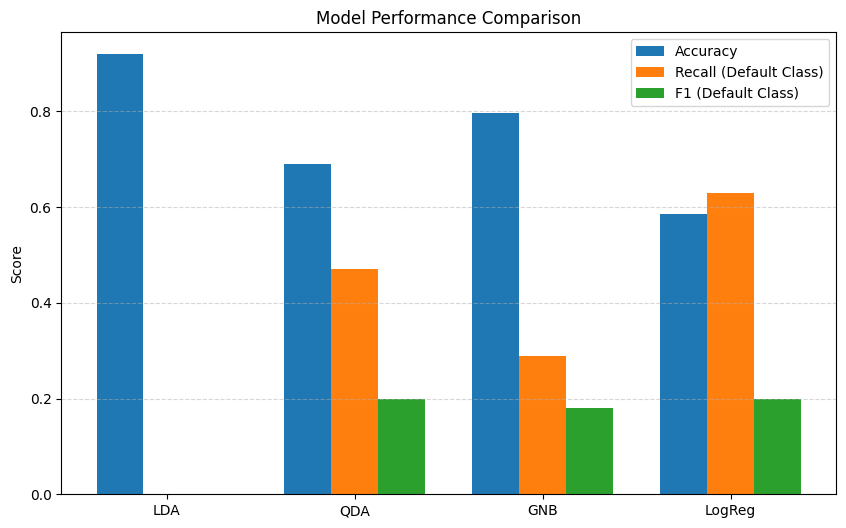

In [ ]:
# VISUAL 2 — Bar chart comparison of Accuracy, Recall, F1

import numpy as np
import matplotlib.pyplot as plt

model_names = ["LDA", "QDA", "GNB", "LogReg"]
accuracy = [0.9195, 0.6910, 0.7967, 0.5867]
recall_1 = [0.00, 0.47, 0.29, 0.63]
f1_1 = [0.00, 0.20, 0.18, 0.20]

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, accuracy, width, label="Accuracy")
plt.bar(x, recall_1, width, label="Recall (Default Class)")
plt.bar(x + width, f1_1, width, label="F1 (Default Class)")

plt.xticks(x, model_names)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


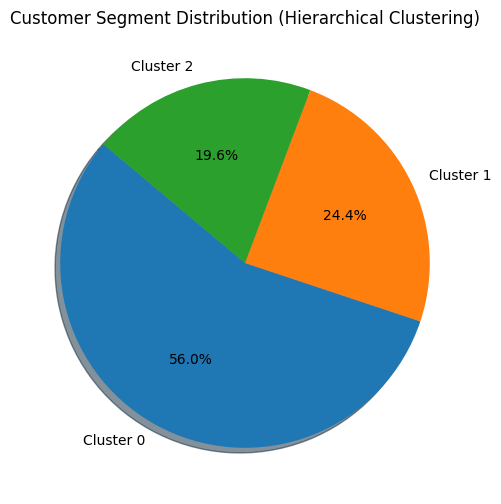

In [ ]:
# VISUAL 3 — Cluster Distribution

plt.figure(figsize=(6,6))
master_df["CLUSTER_ID"].value_counts().plot.pie(
    autopct='%1.1f%%', shadow=True, startangle=140,
    labels=["Cluster 0", "Cluster 1", "Cluster 2"]
)
plt.title("Customer Segment Distribution (Hierarchical Clustering)")
plt.ylabel("")
plt.show()


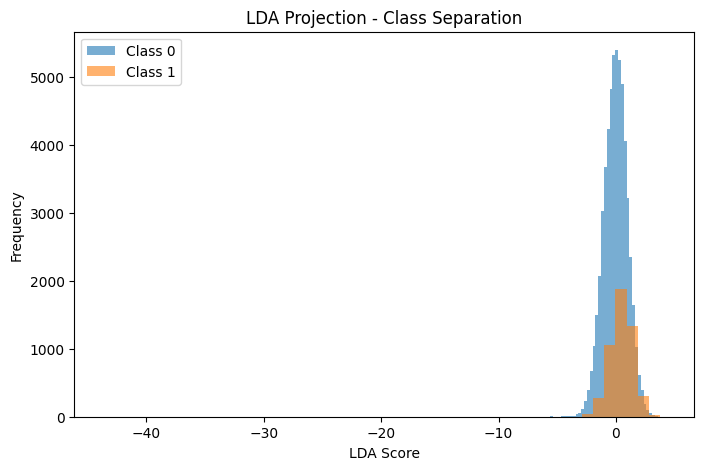

In [ ]:
# VISUAL 4 — LDA projection histogram

lda_scores = lda.transform(X_test)

plt.figure(figsize=(8,5))
plt.hist(lda_scores[y_test == 0], bins=50, alpha=0.6, label="Class 0")
plt.hist(lda_scores[y_test == 1], bins=50, alpha=0.6, label="Class 1")
plt.title("LDA Projection - Class Separation")
plt.xlabel("LDA Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


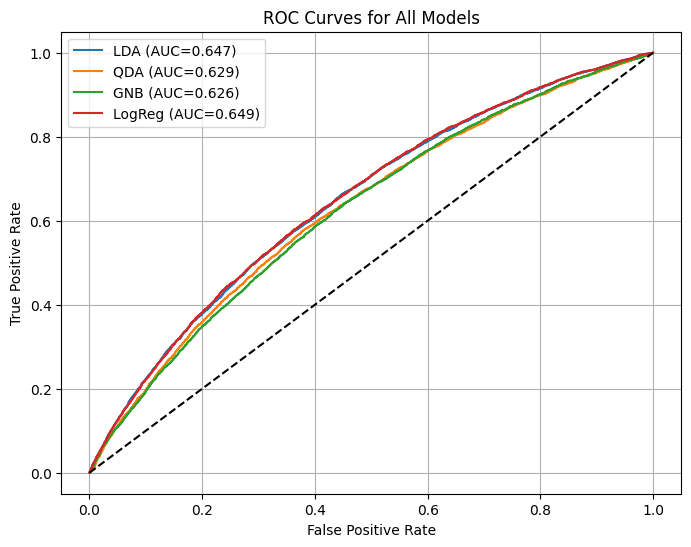

In [ ]:
# VISUAL 5 — Improved ROC Plot

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# CELL — Cronbach Alpha for PCA input features

import numpy as np
import pandas as pd

# Cronbach Alpha function
def cronbach_alpha(df):
    df = df.dropna(axis=0)  # remove missing rows
    k = df.shape[1]          # number of items
    item_var = df.var(axis=0, ddof=1).sum()   # sum of variances
    total_var = df.sum(axis=1).var(ddof=1)    # variance of total score
    alpha = (k / (k - 1)) * (1 - (item_var / total_var))
    return alpha

alpha_value = cronbach_alpha(pd.DataFrame(numeric_var))  # numeric_var is your PCA input before scaling
print("Cronbach Alpha for credit features:", alpha_value)


Cronbach Alpha for credit features: 0.7440102671629188


In [ ]:
# CELL — Extract Bayesian (Gaussian NB) Parameters

import numpy as np
import pandas as pd

# The features used in GNB
X_gnb = X_train.copy()
y_gnb = y_train.copy()

class_labels = np.unique(y_gnb)

bayes_params = {}

for c in class_labels:
    class_data = X_gnb[y_gnb == c]
    mean_vec = class_data.mean(axis=0)
    var_vec = class_data.var(axis=0)
    prior = len(class_data) / len(X_gnb)

    bayes_params[c] = {
        "mean": mean_vec,
        "variance": var_vec,
        "prior": prior
    }

# Print summary for each class
for c in bayes_params:
    print(f"\nClass {c} Bayesian Parameters:")
    print("- Prior:", bayes_params[c]["prior"])
    print("- Mean vector shape:", bayes_params[c]["mean"].shape)
    print("- Variance vector shape:", bayes_params[c]["variance"].shape)



Class 0 Bayesian Parameters:
- Prior: 0.919205879483594
- Mean vector shape: (24,)
- Variance vector shape: (24,)

Class 1 Bayesian Parameters:
- Prior: 0.08079412051640597
- Mean vector shape: (24,)
- Variance vector shape: (24,)
